## Spatial Transformation

In [ ]:
# Analysis
import os
import numpy as np
import pandas as pd
import pickle
import glob

# Plotting
import imageio
import PIL
from PIL import ImageDraw, Image
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

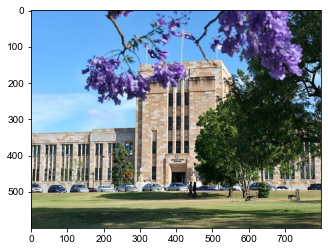

In [4]:
img = cv2.imread('images/uq.jpg') 
img = cv2.cvtColor(img, 4)
plt.imshow(img)

#### Crop

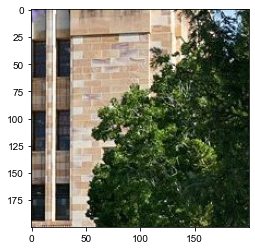

In [219]:
# 截图
plt.imshow(img[200:400,400:600]) # 数组按(rol,col)->(H,W)索引

#### Translate

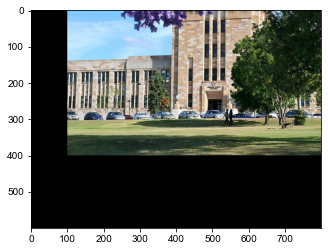

In [17]:
# 平移, 通过矩阵系数 M 对图片元素的坐标位置进行变动 M @ [x1,y1] = [x2,y2]
def translate(img, tx, ty):
    h, w = img.shape[0], img.shape[1]
    M = np.float32([[1,0,tx],[0,1,ty]]) #x轴右移100，y轴上移200
    img_translate=cv2.warpAffine(img,M,(w,h)) 
    return img_translate

img_translate=translate(img, 100, -200) #x轴右移100，y轴上移200
plt.imshow(img_translate)

#### Resize

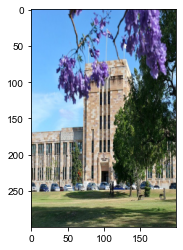

In [17]:
# 缩放
def resize(img, size, method):
    # 方法一：原理
    h, w = img.shape[0], img.shape[1]
    sx = size[0]/w
    sy = size[1]/h
    M = np.float32([[sx,0,0],[0,sy,0]]) 
    img_resize=cv2.warpAffine(img,M,size) #黑底图尺寸 (x,y)->(W,H)，超过部分裁掉
    
    # 方法二：调包，还能指定插值法
    img_resize =cv2.resize(img, size, interpolation=method) #图片按(x,y)->(W,H)索引，
    return img_resize

# 放大图片: cv2.INTER_CUBIC > cv2.INTER_LINEAR > cv2.INTER_NEAREST
# 缩小图片时: cv2.INTER_AREA 
img_resize =resize(img, (200,300), cv2.INTER_AREA)
plt.imshow(img_resize)

#### Flip

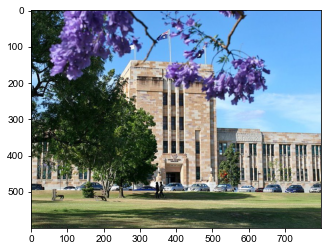

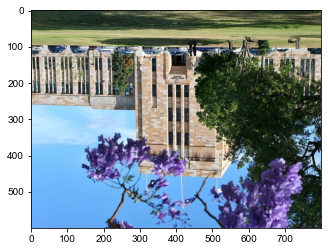

In [15]:
# 镜像，以图像中轴线对称翻转
def flip(img, orient='h'):
    h, w = img.shape[0], img.shape[1]
    if orient=='h':
        # 方法一：原理
        M = np.float32([[-1,0,w-1],[0,1,0]]) #水平翻转
        img_mirror=cv2.warpAffine(img,M,(w,h)) 
        # 方法二：调包
        img_mirror=cv2.flip(img,1) 
    elif orient=='v':
        M = np.float32([[1,0,0],[0,-1,h-1]]) #垂直翻转
        img_mirror=cv2.warpAffine(img,M,(800,600)) 
        img_mirror=cv2.flip(img,0) 
    return img_mirror
        
img_h_mirror = flip(img, 'h')
plt.imshow(img_h_mirror)
plt.show()
img_v_mirror = flip(img, 'v')
plt.imshow(img_v_mirror)

#### Rotate

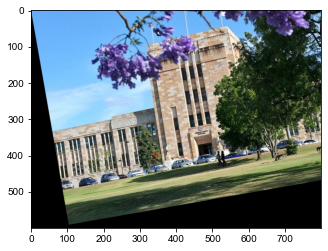

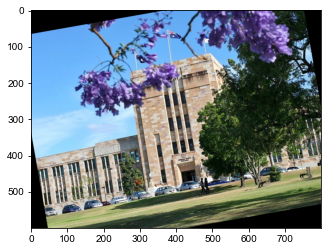

In [30]:
# 旋转
def rotate(img, angle, center=None, scale=1):
    h, w = img.shape[0], img.shape[1]
    
    #方法一：但是若要以图片中心为旋转点，则需要人工计算tx,ty
    radian = angle/180*np.pi #角度转为弧度，默认以左上角(0,0)为旋转点，正数是逆时针
    M = np.float32([[np.cos(radian),np.sin(radian),0],[-np.sin(radian),np.cos(radian),0]])
    
    #方法二: 自定义旋转点，自动计算M
    if center==None:
        center=(0,0)     
    M = cv2.getRotationMatrix2D(center,angle,scale) 
    img_rotate = cv2.warpAffine(img, M, (w,h)) 
    return img_rotate

img_rotate = rotate(img, 10)
plt.imshow(img_rotate)
plt.show()
img_rotate = rotate(img, 10, (400,300))
plt.imshow(img_rotate)

#### Warp

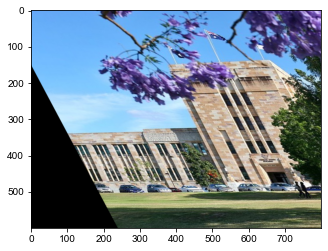

In [7]:
# 拉伸变换，相当于 M @ pts1 = pts2
def warp(img, pts1, pts2):
    h, w = img.shape[0], img.shape[1]
    M = cv2.getAffineTransform(pts1,pts2) # 得到拉伸变换的M矩阵
    img_warp = cv2.warpAffine(img,M,(w,h)) 
    return img_warp

pts1 = np.float32([[50,50],[200,50],[50,200]]) #通过三个点变化前后的(x,y)位置
pts2 = np.float32([[10,50],[200,50],[90,200]]) #左点往左移40，中间点不变，右点往右移40
img_warp = warp(img, pts1, pts2)
plt.imshow(img_warp)

#### Perspective

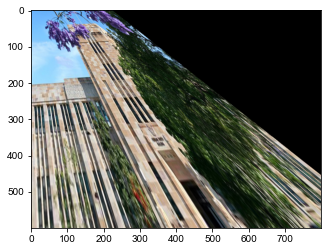

In [47]:
# 透视变换
def perspective(img, pts1, pts2):
    h, w = img.shape[0], img.shape[1]
    M = cv2.getPerspectiveTransform(pts1,pts2) # 得到拉伸变换的M矩阵
    img_pers = cv2.warpPerspective(img,M,(w,h))
    return img_pers

pts1 = np.float32([[56,65],[368,52],[28,387],[389,390]]) #通过四个点变化前后的(x,y)位置
pts2 = np.float32([[0,0],[100,0],[0,300],[300,300]]) #左点往左移40，中间点不变，右点往右移40
img_pers = perspective(img, pts1, pts2)
plt.imshow(img_pers)

#### Interpolation

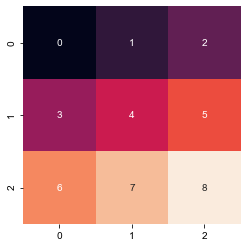

In [2]:
img = np.linspace(0,8,9).reshape([3,3])
sns.heatmap(img, annot=True,cbar=False,square=True);

In [253]:
# 首先在放大后的位置，填充原有像素值
def upsampling(img, size): #img->(h,w,c),size->(w,h)
    h, w = img.shape[0], img.shape[1]
    dst_w, dst_h = size
    sh = int(np.ceil(dst_h/h)) #假设放大3/3.5倍，每隔3/4个格子填充原有像素值
    sw = int(np.ceil(dst_w/w)) #只要有小数就往前进一位
    resize = np.zeros([dst_h,dst_w])
    resize[::sh, ::sw] = img #原坐标(1,1)->新坐标(2,2)
    sns.heatmap(resize, annot=True,cbar=False,square=True)

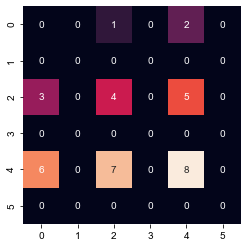

In [270]:
upsampling(img, [6,6])

In [277]:
# 在未填充的空白位置，用最邻近坐标的值填充
def nearest_interpolation(img, size):
    h, w = img.shape[0], img.shape[1]
    dst_w, dst_h = size
    sh = int(np.ceil(dst_h/h)) 
    sw = int(np.ceil(dst_w/w)) 
    
    # 方法一：迭代运算
    resize = np.zeros([dst_h,dst_w])
    for i in range(dst_h):
        for j in range(dst_w):
            y = np.clip(int(round((i+0.5)/sh-0.5)), 0, h-1) #新坐标->对应原坐标的公式，确保原图坐标值范围
            x = np.clip(int(round((j+0.5)/sw-0.5)), 0, w-1) #对应原坐标为小数时(3,3)->(1.25,1.25)，用邻近位置(1,1)的值填充
            resize[i,j] = img[y,x] #新位置值 = 原图对应位置值
    
    # 方法二：矩阵运算    
    y, x = np.mgrid[:dst_h, :dst_w] #相当于分别得到resize尺寸坐标的idx矩阵
    y = np.clip(np.round((y+0.5)/sh-0.5).astype('int'), 0, h-1) 
    x = np.clip(np.round((x+0.5)/sw-0.5).astype('int'), 0, w-1) 
    resize = img[y, x] #用矩阵分别索引(y,x)
    
    sns.heatmap(resize, annot=True,cbar=False,square=True)

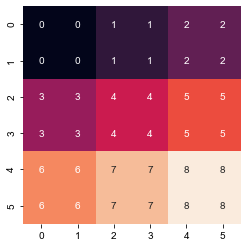

In [279]:
nearest_interpolation(img,[6,6])

In [3]:
def bilinear_interpolation(img, size):
    h, w = img.shape[0], img.shape[1]
    dst_w, dst_h = size
    sh = int(np.ceil(dst_h/h)) 
    sw = int(np.ceil(dst_w/w)) 
    
    resize = np.zeros([dst_h,dst_w])
    for i in range(dst_h):
        for j in range(dst_w):
            y = (i+0.5)/sh-0.5 #只求小数位坐标
            x = (j+0.5)/sw-0.5 
            x1,y1 = np.clip(int(x),0,w-1), np.clip(int(y),0,h-1) #得到4邻域坐标
            x2,y2 = np.clip(x1+1,0,w-1), np.clip(y1+1,0,h-1)
            resize[i,j] = (x2-x)*(y2-y)*img[y1,x1] + (x-x1)*(y2-y)*img[y1,x2] +\
                          (x2-x)*(y-y1)*img[y2,x1] + (x-x1)*(y-y1)*img[y2,x2]
    
    y, x = np.mgrid[:dst_h, :dst_w] #相当于分别得到resize尺寸坐标的idx矩阵
    y = (y+0.5)/sh-0.5
    x = (x+0.5)/sw-0.5
    x1, y1 = np.clip(x.astype('int'), 0, w-1), np.clip(y.astype('int'), 0, h-1)
    x2, y2 = np.clip(x1+1, 0, w-1), np.clip(y1+1, 0, h-1) 
    resize = (x2-x)*(y2-y)*img[y1,x1] + (x-x1)*(y2-y)*img[y1,x2] +\
            (x2-x)*(y-y1)*img[y2,x1] + (x-x1)*(y-y1)*img[y2,x2] 
    sns.heatmap(resize, annot=True,cbar=False,square=True)

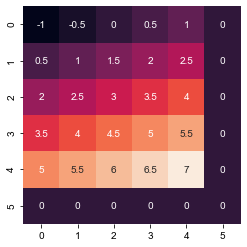

In [4]:
bilinear_interpolation(img,[6,6])